<a href="https://colab.research.google.com/github/phaustin/a301_extras/blob/main/notebooks/week10/read_landsat_ee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# An Intro to the Earth Engine Python API

Adapted from the Google earth engine example page for ATSC 301
-- under construction

Short demo to show some of the functionality of the
[Google Earth Engine Python API](https://developers.google.com/earth-engine/guides/python_install) is presented.

Specificaly -- we:

- search for landsat images  within a date range containing
  a point (UBC Vancouver)
- filter the images for cloud cover
- clip to a region of interest
- mask for cloud and water
- extract band 5 and scale it
- display band 5 on a map
- write it out as a tiff file
- mount a google drive and read it back in using rioxarray
- plot it with rioxarray


In [142]:
import ee
import geemap.core as geemap
import geemap as gem

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-a301')

## Search for cloud-free images

In [143]:
ubc_lon = -123.2460 #degrees West
ubc_lat = 49.2606  # degrees North

Find scenes in July and August between 2000 and 2002 that contain UBC

In [144]:
# Load Landsat 7 data, filter by date, month, and bounds.
collection = (
    ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
    # Two years of data
    .filterDate('2000-01-01', '2002-01-01')
    # Only July-Aug observations
    .filter(ee.Filter.calendarRange(7, 8, 'month'))
    # Intersecting ROI
    .filterBounds(ee.Geometry.Point(ubc_lon, ubc_lat))
)

In [145]:
cloud_cover_values = collection.aggregate_array('CLOUD_COVER').getInfo()
print(cloud_cover_values)

[52, 1, 82, 23, 96, 73, 20, 35, 3, 37, 26, 82]


## Filter on cloud cover

In [146]:
# prompt: filter on cloud fraction less than 10

# Filter the collection to select scenes with less than 10% cloud cover
collection = collection.filter(ee.Filter.lt('CLOUD_COVER', 10))

# Print the number of scenes in the filtered collection
print('Number of scenes with less than 10% cloud cover:', collection.size().getInfo())

# ... (rest of your code)


Number of scenes with less than 10% cloud cover: 2


## Clip to a region

In [147]:
 # prompt: clip collection to a roi of 10 km around (ubc_lon, ubc_lat)

# Define the region of interest (ROI)
roi = ee.Geometry.Point(ubc_lon, ubc_lat).buffer(10000) # 10 km buffer

# Clip the image collection to the ROI
clipped_collection = collection.map(lambda image: image.clip(roi))

# Print the number of scenes in the clipped collection
print('Number of scenes in the clipped collection:', clipped_collection.size().getInfo())

Number of scenes in the clipped collection: 2


## Mask on clouds and water

In [148]:
# prompt: mask the image for cloud and water

# Function to mask clouds and water
def maskCloudsAndWater(image):
    qa = image.select('QA_PIXEL')
    # Bits 3 and 5 are cloud shadow and cloud, respectively.
    cloud = qa.bitwiseAnd(1 << 3).eq(0)
    cloudShadows = qa.bitwiseAnd(1 << 5).eq(0)
    # Water bit
    water = qa.bitwiseAnd(1 << 2).eq(0)  # Assuming bit 2 represents water
    mask = cloud.And(cloudShadows).And(water)
    return image.updateMask(mask)

# Apply the cloud and water masking function to the image collection
masked_collection = clipped_collection.map(maskCloudsAndWater)


## Select and scale band 5

In [149]:
image2 = ee.Image(masked_collection.toList(masked_collection.size()).get(1))
band_sr5 = image2.select('SR_B5')

In [150]:
scale_factor = 0.0000275
add_factor = -0.2
band_sr5= band_sr5.multiply(scale_factor).add(add_factor)

## Display on a map

In [151]:
Map = gem.Map()
Map.centerObject(ee.Geometry.Point([ubc_lon, ubc_lat]),  12)

# Add the image to the map.
vis_params = {'min': 0, 'max': 0.3}
Map.addLayer(band_sr5, vis_params, 'Landsat 7 SR_B5')

# Display the map.
Map


Map(center=[49.2606, -123.24600000000001], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

## Export to a tiff file

Note that the file won't be overwritten, if you want to replace
it you need to use the pathlib module to check if it exists and
then unlink

### Delete the file if it exists

In [152]:
filename = "band_sr5_masked.tif"
folder = folder
from pathlib import Path
the_file = Path(f"/content/drive/MyDrive/{folder}").glob(f"**/{filename}")
the_file = list(the_file)
if the_file:
  the_file[0].unlink()

### Write out the tiff

In [153]:
filestem = Path(filename).stem
filestem

'band_sr5_masked'

In [154]:
# prompt: save band_sr5 as a downloadable tiff file

# Export the image as a GeoTIFF to your Google Drive.
task = ee.batch.Export.image.toDrive(**{
    'image': band_sr5,
    'description': 'band_sr5_export',
    'folder': folder,
    'fileNamePrefix': filestem,
    'region': roi,
    'scale': 30,
    'maxPixels': 1e13
})
task.start()

# Wait for the export task to complete (optional)
import time
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)
print('Task completed!')





Polling for task (id: F55KKKUVGRTL2YXZNE3MP3HK).
Polling for task (id: F55KKKUVGRTL2YXZNE3MP3HK).
Polling for task (id: F55KKKUVGRTL2YXZNE3MP3HK).
Polling for task (id: F55KKKUVGRTL2YXZNE3MP3HK).
Polling for task (id: F55KKKUVGRTL2YXZNE3MP3HK).
Polling for task (id: F55KKKUVGRTL2YXZNE3MP3HK).
Task completed!


## Mount the google drive and read the image


In [155]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
!ls -l /content/drive/MyDrive/earth_engine_downloads

total 3033
-rw------- 1 root root  970360 Mar 18 23:02 'band_sr5 (1).tif'
-rw------- 1 root root  970360 Mar 18 23:51  band_sr5_masked.tif
-rw------- 1 root root 1163407 Mar 18 22:27  band_sr5.tif


## Read and plot the image with rioxarray

Uncomment the next line to install rioxarray

In [157]:
#!pip install rioxarray

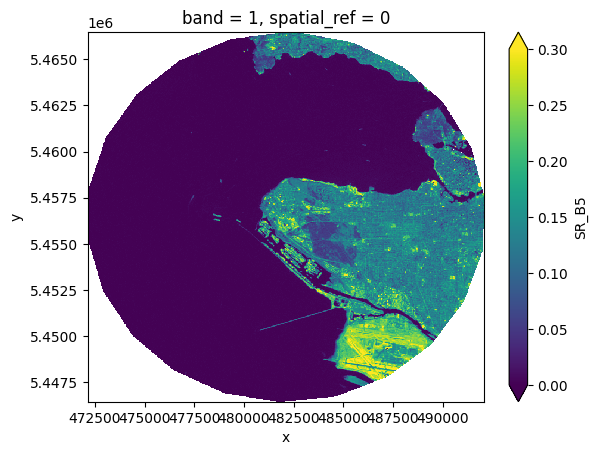

In [158]:
import rioxarray
band5 = rioxarray.open_rasterio('/content/drive/MyDrive/earth_engine_downloads/band_sr5_masked.tif',mask_and_scale=True)
band5 = band5.squeeze()
band5.plot.imshow(vmin=0,vmax=0.3);

band5.plot.hist();

## Doing batch downloads

Haven't tried this, but [geedim](https://github.com/leftfield-geospatial/geedim) looks promissing for batch downloads